# Classification des races de chiens (Top 10)
Ce notebook entraîne un CNN sur les 10 races de chiens les plus représentées du Stanford Dogs Dataset.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S

import time
import albumentations as A
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold

2025-06-26 13:19:21.350995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750943961.551745      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750943961.608511      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Fonctions

In [2]:
def apply_preprocess(x, y):
    x = x * 255.0
    x = resnet_preprocess(x)
    return x, y

def apply_preprocess_efficientnet(x, y):
    x = x * 255.0
    x = efficientnet_preprocess(x)
    return x, y

def cosine_decay(epoch):
    return LR_INIT * 0.5 * (1 + np.cos(np.pi * epoch / EPOCHS))

def make_dataset(paths, labels, transform, batch_size, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=42)

    def _load_and_transform(path, label):
        # path, label sont tf.Tensor scalar
        # on les convertit en NumPy via Albumentations
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3).numpy()     # uint8 H×W×3
        aug = transform(image=img)['image']                     # C×H×W tensor ou array
        # si ToTensorV2() → torch tensor ; convertissez en numpy
        if hasattr(aug, 'numpy'):
            aug = aug.numpy()
        # on remet en H×W×C float32 [0–1]
        aug = aug.transpose(1,2,0).astype(np.float32)
        return aug, label

    def _transform_py(path, label):
        aug, lab = tf.py_function(
            _load_and_transform, [path, label], [tf.float32, tf.int32]
        )
        # **Ici on informe TF de la forme exacte** :
        aug.set_shape([TARGET_SIZE, TARGET_SIZE, 3])
        lab.set_shape([])  # label scalaire
        return aug, lab

    ds = ds.map(_transform_py, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def smooth(y, α=0.8):
    s = [y[0]]
    for yi in y[1:]:
        s.append(α*s[-1] + (1-α)*yi)
    return s

## Sélection des 10 races les plus fréquentes

In [3]:
raw_dir = "/kaggle/input/stanford-dogs-dataset/Images"

# Comptage du nombre d'images par race
counts = {}
for breed in os.listdir(raw_dir):
    path = os.path.join(raw_dir, breed)
    if os.path.isdir(path):
        counts[breed] = len(os.listdir(path))

# On trie par fréquence et on garde les 10 premières
top10 = sorted(counts, key=counts.get, reverse=True)[:10]
print("Top 10 des races :", top10)

Top 10 des races : ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg']


In [4]:
class_names = [
    'Maltese dog','Afghan hound','Scottish deerhound','Pomeranian',
    'Bernese mountain dog','Samoyed','Irish wolfhound','Shih Tzu',
    'Great Pyrenees','Leonberg'
]

### Nombre d'images pas race

In [5]:
top10images = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:10]
for cls, cnt in top10images:
    print(f"{cls}: {cnt} images")

n02085936-Maltese_dog: 252 images
n02088094-Afghan_hound: 239 images
n02092002-Scottish_deerhound: 232 images
n02112018-Pomeranian: 219 images
n02107683-Bernese_mountain_dog: 218 images
n02111889-Samoyed: 218 images
n02090721-Irish_wolfhound: 218 images
n02086240-Shih-Tzu: 214 images
n02111500-Great_Pyrenees: 213 images
n02111129-Leonberg: 210 images


## Configuration des paramètres

In [6]:
BATCH_SIZE = 32
NUM_CLASSES = len(top10)
TARGET_SIZE = 224
LR_INIT    = 1e-4
EPOCHS     = 30

### Moyenne des flux

In [7]:
means, stds = [], []
for cls in top10:
    for fname in os.listdir(os.path.join(raw_dir, cls)):
        img = cv2.imread(os.path.join(raw_dir, cls, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        means.append(img.mean(axis=(0,1)))
        stds .append(img.std(axis=(0,1)))

dataset_mean = np.mean(means, axis=0)
dataset_std  = np.mean(stds,  axis=0)
print("Mean:", dataset_mean, "Std:", dataset_std)

Mean: [0.46580702 0.44905666 0.39209118] Std: [0.22929382 0.22483523 0.22733563]


## Générateurs d'images avec augmentation

### Augmentations

In [8]:
train_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=1),    
    A.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist()),
    
    A.ShiftScaleRotate(
    shift_limit=0.2,    # ±10% de décalage
    scale_limit=0.2,    # ±10% de zoom
    rotate_limit=40,    # ±20° de rotation
    p=0.7),
    
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.MedianBlur(blur_limit=5, p=0.3),
    A.pytorch.transforms.ToTensorV2(),
])

# 1.2 Pipeline de validation (déterministe)
val_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),    
    A.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist()),
    A.pytorch.transforms.ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),    
    A.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist()),
    A.pytorch.transforms.ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### Création des chemins et des target

In [9]:
all_images, all_labels = [], []
class_to_idx = {cls_name: i for i, cls_name in enumerate(top10)}

means, stds = [], []
for cls_name in top10:
    folder = os.path.join(raw_dir, cls_name)
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        all_images.append(path)
        all_labels.append(class_to_idx[cls_name])

### Séparation des datasets (80%/10%/10%)

In [10]:
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    all_images, all_labels,
    test_size=0.10,           
    stratify=all_labels,
    random_state=42
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=1/9,
    stratify=train_val_labels,
    random_state=42
)

print(f"Train : {len(train_paths)} images")
print(f"Val   : {len(val_paths)} images")
print(f"Test  : {len(test_paths)} images") 

Train : 1785 images
Val   : 224 images
Test  : 224 images


### Création des datasets augmentés

In [11]:
train_ds = make_dataset(train_paths, train_labels, train_transform, BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(val_paths,   val_labels,   val_transform,   BATCH_SIZE, shuffle=False)
test_ds   = make_dataset(test_paths,   test_labels,   test_transform,   BATCH_SIZE, shuffle=False)

I0000 00:00:1750944032.898117      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750944032.898814      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### Appel aux fonctions de prétraitement

In [12]:
train_ds_resnet = train_ds.map(apply_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_resnet   = val_ds.map(apply_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)
test_ds_resnet   = test_ds.map(apply_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)

train_ds_efficientnet = train_ds.map(apply_preprocess_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_efficientnet   = val_ds.map(apply_preprocess_efficientnet,   num_parallel_calls=tf.data.AUTOTUNE)
test_ds_efficientnet   = test_ds.map(apply_preprocess_efficientnet,   num_parallel_calls=tf.data.AUTOTUNE)

# Définition du modèle ResNet50

In [13]:
def build_model_resnet():
    base = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3))
    
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base.input, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name='top_1'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3'),
        ]
    )
    return model
    
build_model_resnet().summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
model_resnet = build_model_resnet()

## Entraînement du modèle

In [15]:
start_time = time.time()

history_resnet = model_resnet.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=EPOCHS,
    callbacks=[LearningRateScheduler(cosine_decay)],
)

end_time = time.time()
total_time = end_time - start_time
minutes_resnet = total_time // 60
seconds_resnet = total_time % 60

Epoch 1/30


I0000 00:00:1750944086.525535      64 service.cc:148] XLA service 0x7e076c00a850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750944086.526291      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750944086.526322      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750944091.681827      64 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750944114.146855      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 130s 978ms/step - loss: 2.3023 - top_1: 0.2629 - top_3: 0.5141 - val_loss: 1.2933 - val_top_1: 0.6875 - val_top_3: 0.9241 - learning_rate: 1.0000e-04
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 467ms/step - loss: 1.0245 - top_1: 0.6551 - top_3: 0.8769 - val_loss: 0.7185 - val_top_1: 0.8393 - val_top_3: 0.9688 - learning_rate: 9.9726e-05
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - loss: 0.7821 - top_1: 0.7289 - top_3: 0.9265 - val_loss: 0.5263 - val_top_1: 0.8438 - val_top_3: 0.9732 - learning_rate: 9.8907e-05
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 467ms/step - loss: 0.6701 - top_1: 0.7665 - top_3: 0.9477 - val_loss: 0.5705 - val_top_1: 0.8393 - val_top_3: 0.9777 - learning_rate: 9.7553e-05
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 469ms/step - loss: 0.5963 - top_1: 0.8007 - top_3: 0.9509 - val_loss: 0.5090 - val_top_1: 0.8438 - val_top_3: 0.9777 - learning_rate: 9.5677e-05
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 468ms/step - loss: 0.5614 - top_1

## Évaluation

In [16]:
results = model_resnet.evaluate(test_ds_resnet, return_dict=True)
print(f"Temps d'entraînement : {int(minutes_resnet)} min {seconds_resnet:.1f} s")
print(f"Validation loss     = {results['loss']:.3f}")
print(f"Validation Top-1    = {results['top_1']:.3%}")
print(f"Validation Top-3    = {results['top_3']:.3%}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.3603 - top_1: 0.9087 - top_3: 0.9744
Temps d'entraînement : 15 min 5.5 s
Validation loss     = 0.405
Validation Top-1    = 89.286%
Validation Top-3    = 97.321%


## Courbes

F1-score macro sur validation : 0.8708


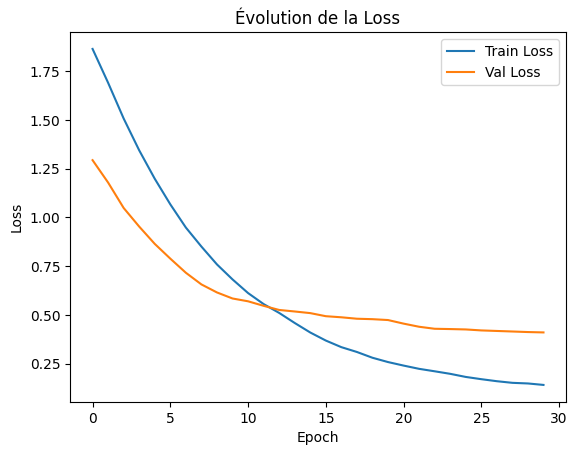

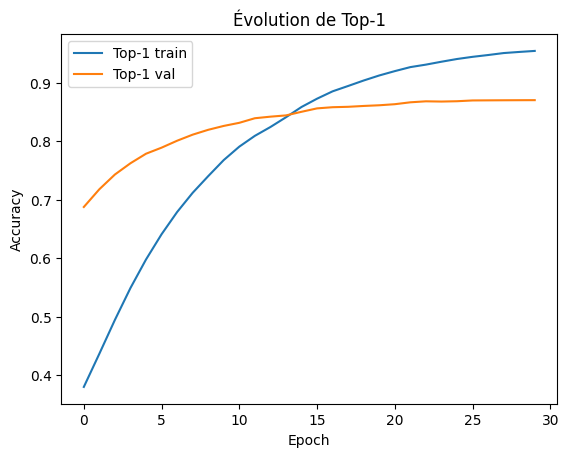

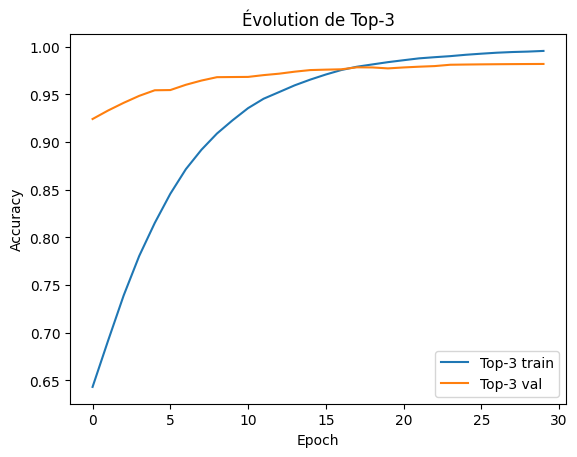

In [17]:
y_true = []
y_pred = []

for images, labels in val_ds_resnet:
    probs = model_resnet.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_pred.extend(preds.tolist())
    y_true.extend(labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

f1_macro_resnet = f1_score(y_true, y_pred, average='macro')
print(f"F1-score macro sur validation : {f1_macro_resnet:.4f}")

plt.figure()
plt.plot(smooth(history_resnet.history['loss']), label='Train Loss')
plt.plot(smooth(history_resnet.history['val_loss']), label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Évolution de la Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(smooth(history_resnet.history['top_1']), label='Top-1 train')
plt.plot(smooth(history_resnet.history['val_top_1']), label='Top-1 val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Évolution de Top-1')
plt.show()

plt.figure()
plt.plot(smooth(history_resnet.history['top_3']), label='Top-3 train')
plt.plot(smooth(history_resnet.history['val_top_3']), label='Top-3 val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Évolution de Top-3')
plt.show()

## Matrice de confusion

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step


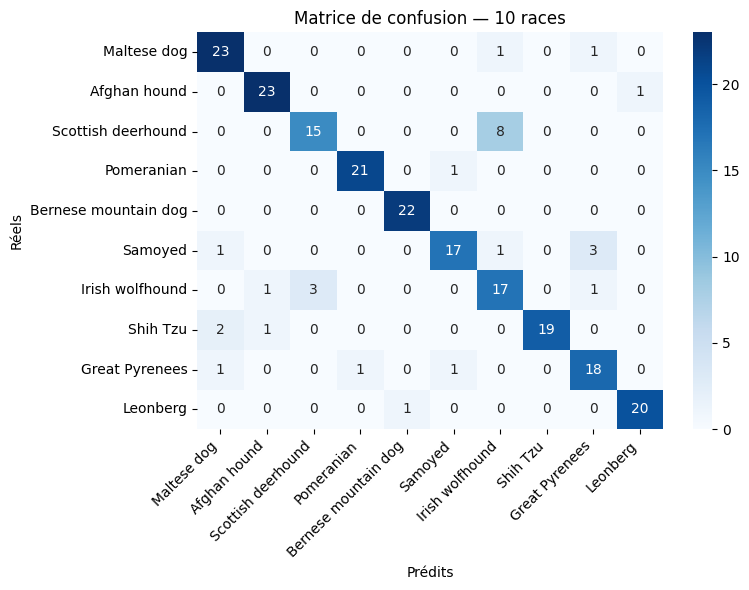

In [18]:
y_prob = model_resnet.predict(val_ds_resnet) 
y_pred = np.argmax(y_prob, axis=1)
y_true = np.array(val_labels)   

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel("Prédits")
plt.ylabel("Réels")
plt.title("Matrice de confusion — 10 races")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# EFFICIENTNETV2

In [19]:
tf.config.optimizer.set_jit(True)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [20]:
def build_model_efficientnet():
    base = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE, TARGET_SIZE, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.2)(x)
    out = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)  
    
    model = Model(inputs=base.input, outputs=out)
    
    model.compile(
        optimizer=Adam(learning_rate=LR_INIT),
        loss="sparse_categorical_crossentropy",
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name='top_1'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3'),
        ]
    )
    return model
    
build_model_efficientnet().summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)    

 Total params: 20,344,170 (77.61 MB)

 Trainable params: 20,190,298 (77.02 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [21]:
model_efficientnet = build_model_efficientnet()

## Entraînement du modèle

In [22]:
start_time = time.time()

history = model_efficientnet.fit(
    train_ds_efficientnet,
    validation_data=val_ds_efficientnet,
    epochs=EPOCHS,
    callbacks=[LearningRateScheduler(cosine_decay)],
)

end_time = time.time()
total_time = end_time - start_time
minutes_efficientnet = total_time // 60
seconds_efficientnet = total_time % 60

Epoch 1/30


2025-06-26 13:38:39.756600: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=2} for conv (f16[192,3,3,48]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,56,56,48]{3,2,1,0}, f16[32,56,56,192]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-26 13:38:39.824182: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.067766486s
Trying algorithm eng19{k2=2} for conv (f16[192,3,3,48]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,56,56,48]{3,2,1,0}, f16[32,56,56,192]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config"

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 2.1088 - top_1: 0.2630 - top_3: 0.5177

2025-06-26 13:40:24.519647: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=3} for conv (f16[192,3,3,48]{3,2,1,0}, u8[0]{0}) custom-call(f16[25,56,56,48]{3,2,1,0}, f16[25,56,56,192]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-26 13:40:24.901527: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.382063496s
Trying algorithm eng19{k2=3} for conv (f16[192,3,3,48]{3,2,1,0}, u8[0]{0}) custom-call(f16[25,56,56,48]{3,2,1,0}, f16[25,56,56,192]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config"

56/56 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - loss: 2.0987 - top_1: 0.2685 - top_3: 0.5232 - val_loss: 0.6835 - val_top_1: 0.8482 - val_top_3: 0.9777 - learning_rate: 1.0000e-04
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - loss: 1.0226 - top_1: 0.6957 - top_3: 0.8971 - val_loss: 0.3085 - val_top_1: 0.9107 - val_top_3: 0.9955 - learning_rate: 9.9726e-05
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - loss: 0.5951 - top_1: 0.8075 - top_3: 0.9659 - val_loss: 0.2536 - val_top_1: 0.9062 - val_top_3: 1.0000 - learning_rate: 9.8907e-05
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - loss: 0.4086 - top_1: 0.8591 - top_3: 0.9794 - val_loss: 0.2530 - val_top_1: 0.9152 - val_top_3: 1.0000 - learning_rate: 9.7553e-05
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - loss: 0.3378 - top_1: 0.8917 - top_3: 0.9885 - val_loss: 0.2498 - val_top_1: 0.9330 - val_top_3: 1.0000 - learning_rate: 9.5677e-05
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - loss: 0.3396 - top_1: 0

## Évaluation du modèle

In [23]:
results = model_efficientnet.evaluate(test_ds_efficientnet, return_dict=True)
print(f"Temps d'entraînement : {int(minutes_efficientnet)} min {seconds_efficientnet:.1f} s")
print(f"Validation loss     = {results['loss']:.3f}")
print(f"Validation Top-1    = {results['top_1']:.3%}")
print(f"Validation Top-3    = {results['top_3']:.3%}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.1684 - top_1: 0.9577 - top_3: 0.9952
Temps d'entraînement : 12 min 32.3 s
Validation loss     = 0.184
Validation Top-1    = 95.536%
Validation Top-3    = 99.554%


## Courbes

F1-score macro sur validation : 0.9321


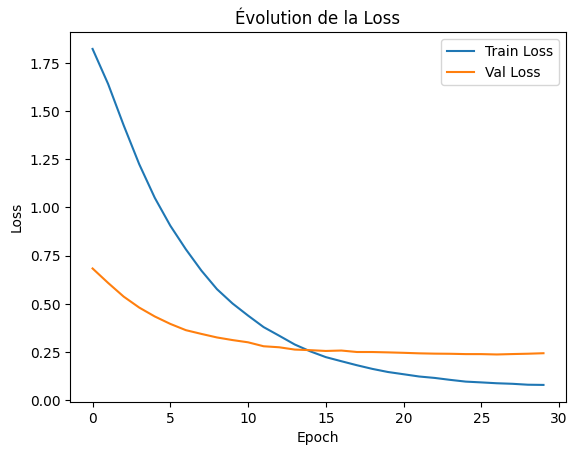

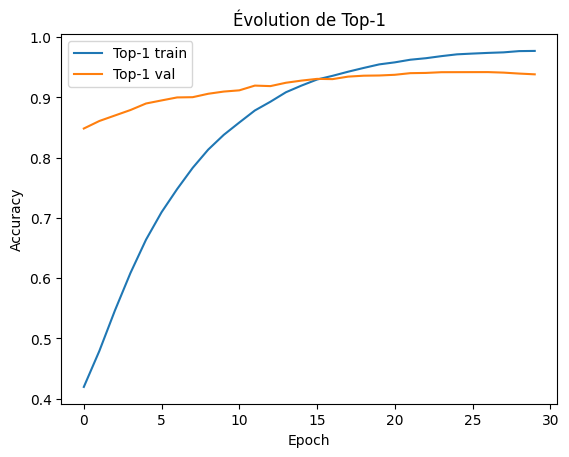

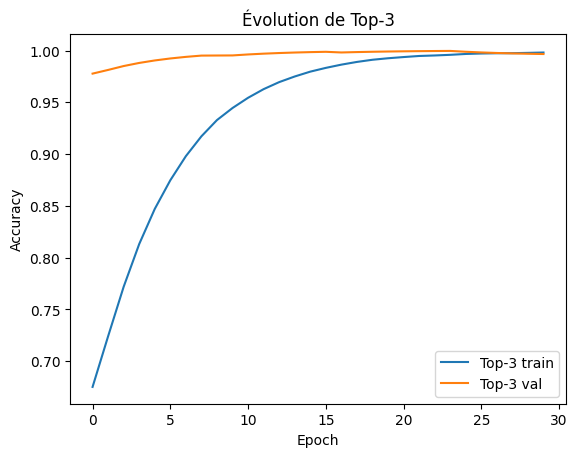

In [24]:
y_true = []
y_pred = []

for images, labels in val_ds_efficientnet:
    probs = model_efficientnet.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_pred.extend(preds.tolist())
    y_true.extend(labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

f1_macro_efficientnet = f1_score(y_true, y_pred, average='macro')
print(f"F1-score macro sur validation : {f1_macro_efficientnet:.4f}")

plt.figure()
plt.plot(smooth(history.history['loss']), label='Train Loss')
plt.plot(smooth(history.history['val_loss']), label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Évolution de la Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(smooth(history.history['top_1']), label='Top-1 train')
plt.plot(smooth(history.history['val_top_1']), label='Top-1 val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Évolution de Top-1')
plt.show()

plt.figure()
plt.plot(smooth(history.history['top_3']), label='Top-3 train')
plt.plot(smooth(history.history['val_top_3']), label='Top-3 val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Évolution de Top-3')
plt.show()

## Matrice de confusion

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step


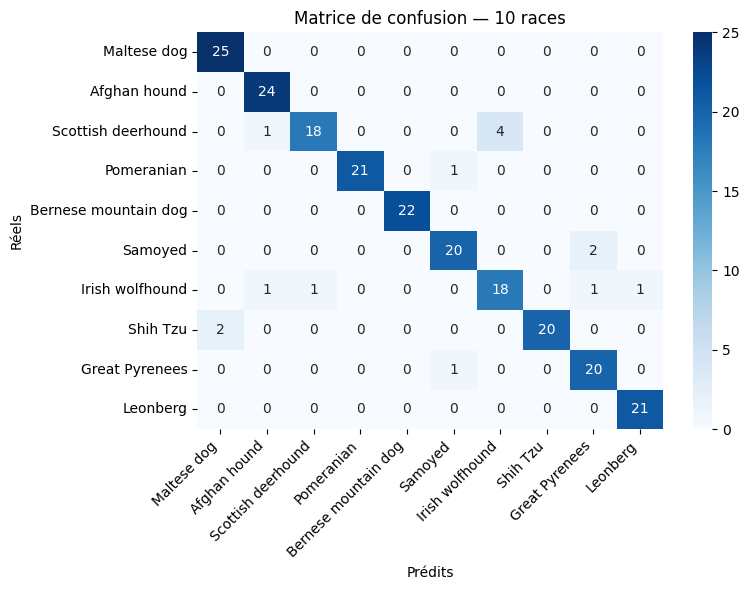

In [25]:
y_prob = model_efficientnet.predict(val_ds_efficientnet)
y_pred = np.argmax(y_prob, axis=1)

y_true = np.array(val_labels) 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel("Prédits")
plt.ylabel("Réels")
plt.title("Matrice de confusion — 10 races")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
def measure_inference_time(model, dataset, n_iters=100):
    times = []
    for _ in range(n_iters):
        it = iter(dataset)
        batch = next(it)[0]
        t0 = time.time()
        _ = model.predict(batch, verbose=0)
        times.append(time.time() - t0)
    return times

times_resnet = measure_inference_time(model_resnet, test_ds_resnet)
times_efficient = measure_inference_time(model_efficientnet, test_ds_efficientnet)

for name, times in [("ResNet-50", times_resnet), ("EffNetV2-S", times_efficient)]:
    arr = np.array(times)
    print(f"{name} — mean: {arr.mean()*1000:.1f} ms, median: {np.median(arr)*1000:.1f} ms, p95: {np.percentile(arr,95)*1000:.1f} ms")

ResNet-50 — mean: 219.8 ms, median: 211.7 ms, p95: 242.3 ms
EffNetV2-S — mean: 168.3 ms, median: 167.7 ms, p95: 184.1 ms


# Comparaison des score des modèles

In [27]:
results = model_resnet.evaluate(test_ds_resnet, return_dict=True)
print("RESNET :")
print(f"Temps d'entraînement : {int(minutes_resnet)} min {seconds_resnet:.1f} s")
print(f"Validation loss     = {results['loss']:.3f}")
print(f"Validation Top-1    = {results['top_1']:.3%}")
print(f"Validation Top-3    = {results['top_3']:.3%}")
print(f"F1-score macro sur validation : {f1_macro_resnet:.4f}")

results = model_efficientnet.evaluate(test_ds_efficientnet, return_dict=True)
print("EFFICIENTNETV2")
print(f"Temps d'entraînement : {int(minutes_efficientnet)} min {seconds_efficientnet:.1f} s")
print(f"Validation loss     = {results['loss']:.3f}")
print(f"Validation Top-1    = {results['top_1']:.3%}")
print(f"Validation Top-3    = {results['top_3']:.3%}")
import joblib
print(f"F1-score macro sur validation : {f1_macro_efficientnet:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.3603 - top_1: 0.9087 - top_3: 0.9744
RESNET :
Temps d'entraînement : 15 min 5.5 s
Validation loss     = 0.405
Validation Top-1    = 89.286%
Validation Top-3    = 97.321%
F1-score macro sur validation : 0.8708
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.1684 - top_1: 0.9577 - top_3: 0.9952
EFFICIENTNETV2
Temps d'entraînement : 12 min 32.3 s
Validation loss     = 0.184
Validation Top-1    = 95.536%
Validation Top-3    = 99.554%
F1-score macro sur validation : 0.9321


In [28]:
model_resnet.save("/kaggle/working/resnet.h5", save_format="h5")
model_efficientnet.save_weights('/kaggle/working/effnet.weights.h5')